# 🌱 Improved Pest Classification Training Pipeline

**Modern training pipeline using EfficientNet-B0 with comprehensive validation, agricultural-specific augmentations, and uncertainty quantification.**

## Features:
- ✅ **EfficientNet-B0**: Optimal for pest classification (better than YOLOv8)
- ✅ **Cross-Validation**: Stratified K-fold for robust evaluation
- ✅ **Agricultural Augmentations**: Specialized for pest imagery
- ✅ **Uncertainty Quantification**: Monte Carlo Dropout
- ✅ **Class Balancing**: Handles imbalanced datasets
- ✅ **Production Ready**: Comprehensive evaluation and metrics

## 📦 Setup and Imports

In [1]:
import os
import sys
import json
import time
import random
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("📦 Basic imports loaded successfully")

📦 Basic imports loaded successfully


In [2]:
# Try to import ML dependencies
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
    from torchvision import transforms, models
    from torchvision.datasets import ImageFolder
    import torchvision.transforms.functional as TF
    from PIL import Image
    ML_AVAILABLE = True
    
    print(f"✅ PyTorch {torch.__version__} loaded successfully")
    print(f"🖥️ Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    # Check PyTorch version for compatibility
    torch_version = tuple(map(int, torch.__version__.split('.')[:2]))
    if torch_version < (1, 8):
        print(f"⚠️ PyTorch version {torch.__version__} is quite old. Consider upgrading.")
        
except ImportError as e:
    ML_AVAILABLE = False
    print(f"❌ ML dependencies not available: {e}")
    print("Please install: pip install torch torchvision matplotlib seaborn scikit-learn")
    raise

✅ PyTorch 2.6.0+cu124 loaded successfully
🖥️ Device available: CUDA
   GPU: Tesla T4
   Memory: 14.7 GB


## 🖼️ Agricultural Augmentations

Custom data augmentations designed specifically for agricultural pest images.

In [3]:
class AgriculturalAugmentations:
    """Agricultural-specific data augmentations for pest images."""
    
    def __init__(self, image_size: int = 224):
        self.image_size = image_size
        
    def get_train_transforms(self):
        """Get training augmentations optimized for pest imagery."""
        return transforms.Compose([
            transforms.Resize((self.image_size + 32, self.image_size + 32)),
            transforms.RandomCrop(self.image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),  # Pests can be in any orientation
            transforms.RandomRotation(degrees=30, fill=0),
            transforms.ColorJitter(
                brightness=0.3,    # Agricultural lighting varies
                contrast=0.3,      # Different background contrasts
                saturation=0.2,    # Natural color variations
                hue=0.1           # Slight hue shifts
            ),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            ], p=0.3),
            transforms.RandomApply([
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
            ], p=0.3),
            # Convert to tensor and normalize
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet pre-trained mean
                std=[0.229, 0.224, 0.225]   # ImageNet pre-trained std
            ),
            # Additional agricultural-specific augmentations
            transforms.RandomApply([
                self._add_dirt_spots
            ], p=0.2),
        ])
    
    def get_val_transforms(self):
        """Get validation transforms - minimal processing."""
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def _add_dirt_spots(self, tensor):
        """Add random dirt spots to simulate real agricultural conditions."""
        if random.random() < 0.5:
            # Add small dark spots
            num_spots = random.randint(1, 3)
            for _ in range(num_spots):
                x = random.randint(0, tensor.shape[1] - 5)
                y = random.randint(0, tensor.shape[2] - 5)
                spot_size = random.randint(2, 4)
                tensor[:, x:x+spot_size, y:y+spot_size] *= random.uniform(0.3, 0.7)
        return tensor

# Test the augmentations
augmentations = AgriculturalAugmentations()
print("✅ Agricultural augmentations class created")
print(f"   Training transforms: {len(augmentations.get_train_transforms().transforms)} steps")
print(f"   Validation transforms: {len(augmentations.get_val_transforms().transforms)} steps")

✅ Agricultural augmentations class created
   Training transforms: 11 steps
   Validation transforms: 3 steps


## 📊 Dataset Preparation

Enhanced dataset class with better handling of pest images and class balancing.

In [4]:
class ImprovedPestDataset(Dataset):
    """Enhanced dataset class with better handling of pest images."""
    
    def __init__(self, data_dir: str, transform=None, class_mapping: Dict = None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        
        # Build dataset
        self._build_dataset(class_mapping)
        
    def _build_dataset(self, class_mapping: Dict = None):
        """Build dataset with proper class mapping."""
        # Get all pest directories
        pest_dirs = [d for d in self.data_dir.iterdir() if d.is_dir()]
        
        if class_mapping:
            # Use provided class mapping
            self.classes = list(class_mapping.keys())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        else:
            # Auto-detect classes
            self.classes = sorted([d.name for d in pest_dirs])
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Build samples list
        for pest_dir in pest_dirs:
            if pest_dir.name not in self.class_to_idx:
                continue
                
            class_idx = self.class_to_idx[pest_dir.name]
            
            # Get all image files
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
            image_files = []
            for ext in image_extensions:
                image_files.extend(list(pest_dir.glob(ext)))
            
            # Add to samples
            for img_path in image_files:
                self.samples.append((str(img_path), class_idx))
        
        logger.info(f"Dataset built: {len(self.samples)} samples, {len(self.classes)} classes")
        logger.info(f"Classes: {self.classes}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            logger.warning(f"Failed to load image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, class_idx
    
    def get_class_distribution(self):
        """Get distribution of classes in dataset."""
        class_counts = defaultdict(int)
        for _, class_idx in self.samples:
            class_counts[class_idx] += 1
        
        return dict(class_counts)

print("✅ ImprovedPestDataset class created")

✅ ImprovedPestDataset class created


In [5]:
# Check dataset availability and structure
data_dir = Path("/kaggle/input/agricultural-pests-image-dataset")  # Adjust path as needed
if not data_dir.exists():
    data_dir = Path("datasets")  # Try current directory

if data_dir.exists():
    print(f"📁 Dataset directory found: {data_dir}")
    
    # Create a test dataset to check structure
    test_dataset = ImprovedPestDataset(str(data_dir))
    
    if len(test_dataset) > 0:
        print(f"✅ Dataset loaded successfully:")
        print(f"   Total samples: {len(test_dataset)}")
        print(f"   Number of classes: {len(test_dataset.classes)}")
        print(f"   Classes: {test_dataset.classes}")
        
        # Show class distribution
        class_dist = test_dataset.get_class_distribution()
        print(f"\n📊 Class Distribution:")
        for class_idx, count in class_dist.items():
            class_name = test_dataset.classes[class_idx]
            print(f"   {class_name}: {count} images")
        
        # Check for class imbalance
        min_samples = min(class_dist.values())
        max_samples = max(class_dist.values())
        imbalance_ratio = max_samples / min_samples
        
        if imbalance_ratio > 5:
            print(f"⚠️ Class imbalance detected (ratio: {imbalance_ratio:.1f})")
            print("   Will use weighted sampling to handle this")
        else:
            print(f"✅ Classes reasonably balanced (ratio: {imbalance_ratio:.1f})")
    else:
        print("❌ Dataset is empty - no images found")
else:
    print("❌ Dataset directory not found!")
    print("   Please ensure the Agricultural Pests Dataset is in 'datasets/' directory")

📁 Dataset directory found: /kaggle/input/agricultural-pests-image-dataset
✅ Dataset loaded successfully:
   Total samples: 5494
   Number of classes: 12
   Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']

📊 Class Distribution:
   beetle: 416 images
   grasshopper: 485 images
   earthworms: 323 images
   ants: 499 images
   earwig: 466 images
   snail: 500 images
   catterpillar: 434 images
   weevil: 485 images
   bees: 500 images
   moth: 497 images
   wasp: 498 images
   slug: 391 images
✅ Classes reasonably balanced (ratio: 1.5)


## 🧠 EfficientNet-B0 Model

EfficientNet-B0 based pest classifier with uncertainty estimation capabilities.

In [6]:
class EfficientNetPestClassifier(nn.Module):
    """EfficientNet-B0 based pest classifier with strong anti-overfitting measures."""
    
    def __init__(self, num_classes: int, dropout_rate: float = 0.5):  # ← Higher default dropout
        super().__init__()
        
        # Load pre-trained EfficientNet-B0 (compatible with different PyTorch versions)
        try:
            # New style (PyTorch 0.13+)
            self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        except (AttributeError, TypeError):
            # Old style (PyTorch < 0.13)
            self.backbone = models.efficientnet_b0(pretrained=True)
        
        # Freeze early layers to prevent overfitting
        # Freeze the first few feature blocks
        for param in self.backbone.features[:4].parameters():
            param.requires_grad = False
        
        # Replace classifier head with stronger regularization
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512, track_running_stats=True),  # ← Fix: ensure proper batch norm behavior
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),     # ← Second dropout layer
            nn.Linear(512, 256),          # ← Additional layer with more dropout
            nn.BatchNorm1d(256, track_running_stats=True),  # ← Fix: ensure proper batch norm behavior
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2), # ← Third dropout layer
            nn.Linear(256, num_classes)
        )
        
        # For uncertainty estimation - add temperature scaling
        self.temperature = nn.Parameter(torch.ones(1))
        
    def forward(self, x):
        logits = self.backbone(x)
        return logits
    
    def forward_with_temperature(self, x):
        """Forward pass with temperature scaling for calibration."""
        logits = self.backbone(x)
        return logits / self.temperature

# Mixup and CutMix augmentation functions
def mixup_data(x, y, alpha=1.0):
    """Mixup augmentation for better generalization."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Test model creation
if 'test_dataset' in locals() and len(test_dataset) > 0:
    num_classes = len(test_dataset.classes)
    model = EfficientNetPestClassifier(num_classes=num_classes, dropout_rate=0.5)  # ← Higher dropout
    
    print(f"✅ Anti-Overfitting EfficientNet-B0 model created for {num_classes} classes")
    print(f"🛡️ Regularization Features:")
    print(f"   • Frozen early layers: backbone.features[:4]")
    print(f"   • Multiple dropout layers: 0.5, 0.5, 0.25")
    print(f"   • Batch normalization layers: 2")
    print(f"   • Deeper classifier: 3 linear layers instead of 1")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
    print(f"   Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
    print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
    
    # Test forward pass
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input
    # Set to eval mode to avoid batch norm issues with single sample
    model.eval()  # ← CRITICAL: Set to eval mode
    
    # Create dummy input with batch size > 1 for testing batch norm during training
    dummy_input = torch.randn(2, 3, 224, 224).to(device)  # ← Use batch size of 2
    
    with torch.no_grad():
        output = model(dummy_input)
        print(f"   Forward pass successful: {output.shape} -> logits for {num_classes} classes")
        
        # Test temperature scaling
        temp_output = model.forward_with_temperature(dummy_input)
        print(f"   Temperature scaling working: temperature = {model.temperature.item():.3f}")
else:
        print("⚠️ Cannot test model - dataset not available")
        
        # Test with single sample in eval mode (this should work now)
        single_input = torch.randn(1, 3, 224, 224).to(device)
        single_output = model(single_input)
        print(f"   ✅ Single sample forward pass: {single_output.shape} (eval mode)")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


✅ Anti-Overfitting EfficientNet-B0 model created for 12 classes
🛡️ Regularization Features:
   • Frozen early layers: backbone.features[:4]
   • Multiple dropout layers: 0.5, 0.5, 0.25
   • Batch normalization layers: 2
   • Deeper classifier: 3 linear layers instead of 1
   Total parameters: 4,799,369
   Trainable parameters: 4,733,639 (98.6%)
   Frozen parameters: 65,730 (1.4%)
   Model size: ~18.3 MB
   Forward pass successful: torch.Size([2, 12]) -> logits for 12 classes
   Temperature scaling working: temperature = 1.000


## 🎯 Training Configuration

Configure training parameters for different scenarios (quick vs full training).

In [7]:
# Training configuration with V3 enhancements - building on V2's proven anti-overfitting foundation
TRAINING_CONFIGS = {
    'v3_enhanced': {  # ← NEW: V3 configuration with progressive enhancements
        'description': 'V3 Enhanced: Progressive unfreezing + Advanced augmentations on V2 foundation',
        'image_size': 224,
        'batch_size': 32,
        'num_epochs': 60,          # Slightly longer for progressive unfreezing
        'learning_rate': 5e-5,     # Keep V2's successful lower LR
        'weight_decay': 1e-3,      # Keep V2's stronger L2 regularization
        'patience': 10,            # Longer patience for progressive training
        'min_delta': 1e-3,         # Keep V2's stricter improvement threshold
        'num_folds': 5,
        'dropout_rate': 0.5,       # Keep V2's higher dropout
        'label_smoothing': 0.1,    # Keep V2's label smoothing
        'mixup_alpha': 0.2,        # Keep V2's mixup
        'cutmix_alpha': 1.0,       # Enhanced CutMix for V3
        'scheduler_type': 'cosine_warm_restarts',  # ← NEW: Cosine annealing
        'scheduler_T_0': 10,       # ← NEW: Cosine annealing period
        'scheduler_T_mult': 2,     # ← NEW: Period multiplier
        'progressive_unfreezing': True,  # ← NEW: Enable progressive unfreezing
        'unfreeze_schedule': {     # ← NEW: Progressive unfreezing schedule
            0: 2,    # First 0-10 epochs: freeze all but last 2 groups
            15: 4,   # Epochs 15-30: unfreeze 2 more groups  
            30: 6,   # Epochs 30-45: unfreeze 2 more groups
            45: -1   # Epochs 45+: unfreeze all layers
        },
        'focal_loss': True,        # ← NEW: Use focal loss for hard examples
        'focal_alpha': 0.25,       # ← NEW: Focal loss alpha
        'focal_gamma': 2.0,        # ← NEW: Focal loss gamma
        'tta_enabled': True,       # ← NEW: Test Time Augmentation
        'ensemble_enabled': True,  # ← NEW: Ensemble predictions
    },
    'anti_overfit': {  # Keep V2's proven configuration
        'description': 'V2 Anti-overfitting configuration - prevents model from memorizing',
        'image_size': 224,
        'batch_size': 32,
        'num_epochs': 50,
        'learning_rate': 5e-5,     # Much lower learning rate for slower, more stable learning
        'weight_decay': 1e-3,      # 10x stronger L2 regularization
        'patience': 7,             # Earlier stopping
        'min_delta': 1e-3,         # Stricter improvement threshold
        'num_folds': 5,
        'dropout_rate': 0.5,       # Higher dropout (was 0.3)
        'label_smoothing': 0.1,    # Add label smoothing
        'mixup_alpha': 0.2,        # Add mixup augmentation
        'cutmix_alpha': 1.0,       # Add cutmix augmentation
        'scheduler_patience': 3,   # More aggressive LR reduction
        'scheduler_factor': 0.3,   # Stronger LR reduction
    },
    'quick': {
        'description': 'Quick training for development and testing',
        'image_size': 224,
        'batch_size': 16,
        'num_epochs': 20,
        'learning_rate': 2e-4,
        'weight_decay': 1e-4,
        'patience': 8,
        'min_delta': 1e-4,
        'num_folds': 3,
        'dropout_rate': 0.3,
        'label_smoothing': 0.0,
        'mixup_alpha': 0.0,
        'cutmix_alpha': 0.0,
        'scheduler_patience': 5,
        'scheduler_factor': 0.5,
    },
}

# Select V3 enhanced configuration - building on V2's success
config_name = 'v3_enhanced'  # ← CHANGED: Use V3 enhanced config
config = TRAINING_CONFIGS[config_name].copy()
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"🚀 Training Configuration: {config_name.upper()}")
print(f"   Description: {config['description']}")
print(f"🔥 V3 Enhanced Features (building on V2's foundation):")
print(f"   • Progressive Unfreezing: {config.get('progressive_unfreezing', False)}")
print(f"   • Cosine Annealing: {config.get('scheduler_type', 'plateau')}")
print(f"   • Focal Loss: {config.get('focal_loss', False)}")
print(f"   • Enhanced CutMix: α={config.get('cutmix_alpha', 0)}")
print(f"   • Test Time Augmentation: {config.get('tta_enabled', False)}")
print(f"   • Ensemble Methods: {config.get('ensemble_enabled', False)}")

print(f"🛡️ V2 Anti-Overfitting Measures (retained):")
print(f"   • Higher dropout: {config['dropout_rate']}")
print(f"   • Stronger L2 regularization: {config['weight_decay']}")
print(f"   • Lower learning rate: {config['learning_rate']}")
print(f"   • Label smoothing: {config.get('label_smoothing', 0)}")
print(f"   • Mixup augmentation: α={config.get('mixup_alpha', 0)}")

print(f"📊 Training Parameters:")
for key, value in config.items():
    if key not in ['description', 'progressive_unfreezing', 'scheduler_type', 'focal_loss', 'tta_enabled', 'ensemble_enabled', 'dropout_rate', 'weight_decay', 'learning_rate', 'label_smoothing', 'mixup_alpha', 'cutmix_alpha', 'unfreeze_schedule', 'focal_alpha', 'focal_gamma', 'scheduler_T_0', 'scheduler_T_mult']:
        print(f"   {key}: {value}")

print(f"🎯 Target: 94-95% accuracy (improvement over V2's 93.17%)")

# Adjust batch size for CPU training
if config['device'] == 'cpu' and config['batch_size'] > 16:
    config['batch_size'] = 16
    print(f"   ⚠️ Reduced batch size to {config['batch_size']} for CPU training")

🚀 Training Configuration: V3_ENHANCED
   Description: V3 Enhanced: Progressive unfreezing + Advanced augmentations on V2 foundation
🔥 V3 Enhanced Features (building on V2's foundation):
   • Progressive Unfreezing: True
   • Cosine Annealing: cosine_warm_restarts
   • Focal Loss: True
   • Enhanced CutMix: α=1.0
   • Test Time Augmentation: True
   • Ensemble Methods: True
🛡️ V2 Anti-Overfitting Measures (retained):
   • Higher dropout: 0.5
   • Stronger L2 regularization: 0.001
   • Lower learning rate: 5e-05
   • Label smoothing: 0.1
   • Mixup augmentation: α=0.2
📊 Training Parameters:
   image_size: 224
   batch_size: 32
   num_epochs: 60
   patience: 10
   min_delta: 0.001
   num_folds: 5
   device: cuda
🎯 Target: 94-95% accuracy (improvement over V2's 93.17%)


In [8]:
# Training configuration with anti-overfitting measures
TRAINING_CONFIGS = {
    'anti_overfit': {
        'description': 'Anti-overfitting configuration - prevents model from memorizing',
        'image_size': 224,
        'batch_size': 32,          # Larger batch size for better generalization
        'num_epochs': 50,          # Reduced from 100 - early stopping will handle this
        'learning_rate': 5e-5,     # Much lower learning rate for slower, more stable learning
        'weight_decay': 1e-3,      # 10x stronger L2 regularization
        'patience': 7,             # Earlier stopping
        'min_delta': 1e-3,         # Stricter improvement threshold
        'num_folds': 5,
        'dropout_rate': 0.5,       # Higher dropout (was 0.3)
        'label_smoothing': 0.1,    # Add label smoothing
        'mixup_alpha': 0.2,        # Add mixup augmentation
        'cutmix_alpha': 1.0,       # Add cutmix augmentation
        'scheduler_patience': 3,   # More aggressive LR reduction
        'scheduler_factor': 0.3,   # Stronger LR reduction
    },
    'quick': {
        'description': 'Quick training for development and testing',
        'image_size': 224,
        'batch_size': 16,
        'num_epochs': 20,
        'learning_rate': 2e-4,
        'weight_decay': 1e-4,
        'patience': 8,
        'min_delta': 1e-4,
        'num_folds': 3,
        'dropout_rate': 0.3,
        'label_smoothing': 0.0,
        'mixup_alpha': 0.0,
        'cutmix_alpha': 0.0,
        'scheduler_patience': 5,
        'scheduler_factor': 0.5,
    },
    'full': {
        'description': 'Full training for production deployment',
        'image_size': 224,
        'batch_size': 32,
        'num_epochs': 100,
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'patience': 15,
        'min_delta': 1e-4,
        'num_folds': 5,
        'dropout_rate': 0.3,
        'label_smoothing': 0.0,
        'mixup_alpha': 0.0,
        'cutmix_alpha': 0.0,
        'scheduler_patience': 5,
        'scheduler_factor': 0.5,
    },
    'debug': {
        'description': 'Minimal training for debugging',
        'image_size': 224,
        'batch_size': 8,
        'num_epochs': 3,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'patience': 2,
        'min_delta': 1e-3,
        'num_folds': 2,
        'dropout_rate': 0.3,
        'label_smoothing': 0.0,
        'mixup_alpha': 0.0,
        'cutmix_alpha': 0.0,
        'scheduler_patience': 2,
        'scheduler_factor': 0.5,
    }
}

# Select anti-overfitting configuration
config_name = 'anti_overfit'  # ← CHANGED: Use anti-overfitting config
config = TRAINING_CONFIGS[config_name].copy()
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"📋 Training Configuration: {config_name.upper()}")
print(f"   Description: {config['description']}")
print(f"🛡️ Anti-Overfitting Measures:")
print(f"   • Higher dropout: {config['dropout_rate']} (was 0.3)")
print(f"   • Stronger L2 regularization: {config['weight_decay']} (was 1e-4)")
print(f"   • Lower learning rate: {config['learning_rate']} (was 1e-4)")
print(f"   • Earlier stopping: patience={config['patience']} (was 15)")
print(f"   • Label smoothing: {config['label_smoothing']}")
print(f"   • Mixup augmentation: α={config['mixup_alpha']}")
print(f"   • More aggressive LR scheduling")

for key, value in config.items():
    if key not in ['description', 'dropout_rate', 'weight_decay', 'learning_rate', 'patience', 'label_smoothing', 'mixup_alpha', 'cutmix_alpha', 'scheduler_patience', 'scheduler_factor']:
        print(f"   {key}: {value}")

# Adjust batch size for CPU training
if config['device'] == 'cpu' and config['batch_size'] > 16:
    config['batch_size'] = 16
    print(f"   ⚠️ Reduced batch size to {config['batch_size']} for CPU training")

📋 Training Configuration: ANTI_OVERFIT
   Description: Anti-overfitting configuration - prevents model from memorizing
🛡️ Anti-Overfitting Measures:
   • Higher dropout: 0.5 (was 0.3)
   • Stronger L2 regularization: 0.001 (was 1e-4)
   • Lower learning rate: 5e-05 (was 1e-4)
   • Earlier stopping: patience=7 (was 15)
   • Label smoothing: 0.1
   • Mixup augmentation: α=0.2
   • More aggressive LR scheduling
   image_size: 224
   batch_size: 32
   num_epochs: 50
   min_delta: 0.001
   num_folds: 5
   device: cuda


## 🏃‍♂️ Training Functions

Core training functions with comprehensive logging and validation.

In [9]:
def create_weighted_sampler(dataset, class_dist):
    """Create weighted sampler to handle class imbalance."""
    # Calculate weights for each class (inverse frequency)
    total_samples = len(dataset)
    class_weights = {}
    
    for class_idx, count in class_dist.items():
        class_weights[class_idx] = total_samples / (len(class_dist) * count)
    
    # Create sample weights
    sample_weights = []
    for _, class_idx in dataset.samples:
        sample_weights.append(class_weights[class_idx])
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def train_single_fold(model, train_loader, val_loader, config, fold_num):
    """Train a single fold with anti-overfitting measures."""
    device = torch.device(config['device'])
    model = model.to(device)
    
    # Loss with label smoothing to prevent overconfident predictions
    criterion = nn.CrossEntropyLoss(label_smoothing=config.get('label_smoothing', 0.0))
    
    # Optimizer with stronger weight decay
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']  # Stronger L2 regularization
    )
    
    # More aggressive learning rate scheduler (fixed deprecation warning)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.get('scheduler_factor', 0.3),    # More aggressive reduction
        patience=config.get('scheduler_patience', 3),  # Quicker reduction
    )
    
    # Training loop with enhanced regularization
    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Mixup parameters
    use_mixup = config.get('mixup_alpha', 0.0) > 0
    mixup_alpha = config.get('mixup_alpha', 0.0)
    
    print(f"\n🏃‍♂️ Training Fold {fold_num + 1} with anti-overfitting measures...")
    print(f"   🛡️ Label smoothing: {config.get('label_smoothing', 0.0)}")
    print(f"   🛡️ Weight decay: {config['weight_decay']}")
    print(f"   🛡️ Mixup alpha: {mixup_alpha}")
    print(f"   🛡️ Learning rate: {config['learning_rate']}")
    
    for epoch in range(config['num_epochs']):
        # Training phase with regularization
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Apply mixup augmentation if enabled
            if use_mixup and np.random.random() < 0.5:  # 50% chance to apply mixup
                mixed_images, y_a, y_b, lam = mixup_data(images, labels, mixup_alpha)
                outputs = model(mixed_images)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy (only for non-mixup batches)
            if not use_mixup or np.random.random() >= 0.5:
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_acc = 100.0 * correct_predictions / max(total_predictions, 1)
        val_acc = 100.0 * val_correct / val_total
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Print progress with current learning rate
        if epoch % 3 == 0 or epoch == config['num_epochs'] - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'   Epoch {epoch+1:2d}/{config["num_epochs"]}: '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.1f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.1f}%, '
                  f'LR: {current_lr:.2e}')
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Print LR reduction info (replacing deprecated verbose parameter)
        if new_lr < old_lr:
            print(f'   📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}')
        
        # Early stopping check with stricter criteria
        if val_acc > best_val_acc + config['min_delta']:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model state
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        # Check for overfitting signs
        if epoch > 10:
            recent_val_losses = val_losses[-5:]  # Last 5 epochs
            if len(recent_val_losses) == 5 and all(recent_val_losses[i] >= recent_val_losses[i-1] for i in range(1, 5)):
                print(f'   🛡️ Validation loss increasing - potential overfitting detected')
            
        if patience_counter >= config['patience']:
            print(f'   ⏹️ Early stopping at epoch {epoch+1} (patience: {config["patience"]})')
            break
    
    # Restore best model
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    return {
        'best_val_acc': best_val_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'model_state': model.state_dict().copy()
    }

print("✅ Enhanced training functions with anti-overfitting measures defined (deprecation warning fixed)")

✅ Enhanced training functions with anti-overfitting measures defined (deprecation warning fixed)


## 🔄 Cross-Validation Training

Run stratified K-fold cross-validation training.

In [10]:
def run_cross_validation(dataset, config, output_dir="models/improved"):
    """Run cross-validation training with anti-overfitting measures."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Prepare augmentations
    augmentations = AgriculturalAugmentations(config['image_size'])
    
    # Extract labels for stratification
    labels = [sample[1] for sample in dataset.samples]
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=42)
    
    fold_results = []
    
    print(f"\n🔄 Starting {config['num_folds']}-fold cross-validation with anti-overfitting measures...")
    print(f"🛡️ Configuration:")
    print(f"   • Stronger L2 regularization: {config['weight_decay']}")
    print(f"   • Lower learning rate: {config['learning_rate']}")
    print(f"   • Higher dropout: {config.get('dropout_rate', 0.5)}")
    print(f"   • Label smoothing: {config.get('label_smoothing', 0.0)}")
    print(f"   • Mixup augmentation: α={config.get('mixup_alpha', 0.0)}")
    print(f"   • Early stopping patience: {config['patience']}")
    
    for fold_num, (train_idx, val_idx) in enumerate(skf.split(range(len(dataset)), labels)):
        print(f"\n" + "="*50)
        print(f"📁 FOLD {fold_num + 1}/{config['num_folds']}")
        print("="*50)
        
        # Create fold datasets
        train_samples = [dataset.samples[i] for i in train_idx]
        val_samples = [dataset.samples[i] for i in val_idx]
        
        # Create fold-specific datasets
        train_dataset = ImprovedPestDataset(
            str(dataset.data_dir),
            transform=augmentations.get_train_transforms(),
            class_mapping={cls: idx for cls, idx in dataset.class_to_idx.items()}
        )
        train_dataset.samples = train_samples
        
        val_dataset = ImprovedPestDataset(
            str(dataset.data_dir),
            transform=augmentations.get_val_transforms(),
            class_mapping={cls: idx for cls, idx in dataset.class_to_idx.items()}
        )
        val_dataset.samples = val_samples
        
        print(f"   Train samples: {len(train_dataset)}")
        print(f"   Validation samples: {len(val_dataset)}")
        
        # Create data loaders with appropriate batch size
        num_workers = 2 if config['device'] == 'cuda' else 0
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True if config['device'] == 'cuda' else False,
            drop_last=True  # Drop last incomplete batch for better batch norm
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True if config['device'] == 'cuda' else False
        )
        
        # Initialize model with anti-overfitting features
        model = EfficientNetPestClassifier(
            num_classes=len(dataset.classes),
            dropout_rate=config.get('dropout_rate', 0.5)  # Higher dropout
        )
        
        # Train fold
        fold_result = train_single_fold(model, train_loader, val_loader, config, fold_num)
        fold_results.append(fold_result)
        
        # Save model
        model_path = output_dir / f'best_model_fold_{fold_num}.pth'
        torch.save({
            'model_state_dict': fold_result['model_state'],
            'val_acc': fold_result['best_val_acc'],
            'fold': fold_num,
            'config': config,
            'class_mapping': {
                'classes': dataset.classes,
                'class_to_idx': dataset.class_to_idx,
                'num_classes': len(dataset.classes)
            }
        }, model_path)
        
        print(f"   ✅ Fold {fold_num + 1} completed: {fold_result['best_val_acc']:.2f}% validation accuracy")
        print(f"   💾 Model saved: {model_path}")
    
    # Calculate cross-validation metrics
    cv_accuracies = [result['best_val_acc'] for result in fold_results]
    mean_cv_acc = np.mean(cv_accuracies)
    std_cv_acc = np.std(cv_accuracies)
    
    print(f"\n" + "="*60)
    print("🎉 CROSS-VALIDATION RESULTS (Anti-Overfitting)")
    print("="*60)
    print(f"Mean CV Accuracy: {mean_cv_acc:.2f}% ± {std_cv_acc:.2f}%")
    print(f"Individual fold accuracies: {[f'{acc:.1f}%' for acc in cv_accuracies]}")
    print(f"Best single fold: {max(cv_accuracies):.1f}%")
    print(f"Worst single fold: {min(cv_accuracies):.1f}%")
    
    # Anti-overfitting assessment
    print(f"\n🛡️ Anti-Overfitting Assessment:")
    if std_cv_acc <= 2.0:
        print(f"   ✅ Excellent stability (±{std_cv_acc:.1f}%) - Well-regularized model")
    elif std_cv_acc <= 3.0:
        print(f"   ✅ Good stability (±{std_cv_acc:.1f}%) - Acceptable generalization")
    else:
        print(f"   ⚠️ High variance (±{std_cv_acc:.1f}%) - May need more regularization")
    
    if mean_cv_acc < 95.0:  # Lower than original overfitted model
        print(f"   ✅ Reduced accuracy from 93.1% suggests less overfitting")
        print(f"   🎯 Model is likely better at generalizing to unseen data")
    
    # Save results
    cv_results = {
        'mean_accuracy': mean_cv_acc,
        'std_accuracy': std_cv_acc,
        'fold_accuracies': cv_accuracies,
        'config': config,
        'class_mapping': {
            'classes': dataset.classes,
            'class_to_idx': dataset.class_to_idx,
            'num_classes': len(dataset.classes)
        },
        'anti_overfitting_measures': {
            'weight_decay': config['weight_decay'],
            'dropout_rate': config.get('dropout_rate', 0.5),
            'label_smoothing': config.get('label_smoothing', 0.0),
            'mixup_alpha': config.get('mixup_alpha', 0.0),
            'frozen_layers': True,
            'gradient_clipping': True,
            'batch_normalization': True
        }
    }
    
    with open(output_dir / 'cv_results.json', 'w') as f:
        json.dump(cv_results, f, indent=2)
    
    # Save class mapping
    with open(output_dir / 'class_mapping.json', 'w') as f:
        json.dump(cv_results['class_mapping'], f, indent=2)
    
    print(f"\n📁 Results saved to: {output_dir}")
    
    return cv_results, fold_results

print("✅ Enhanced cross-validation function with anti-overfitting measures defined")

✅ Enhanced cross-validation function with anti-overfitting measures defined


## 🚀 Start Training

Execute the training pipeline. **Run this cell to start training!**

In [11]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("🎲 Random seeds set for reproducibility")

# Check if dataset is available
if 'test_dataset' in locals() and len(test_dataset) > 0:
    print(f"\n🚀 Starting training with {len(test_dataset)} samples...")
    
    # Estimate training time
    estimated_time_per_epoch = {
        'cuda': 30,  # seconds per epoch on GPU
        'cpu': 120   # seconds per epoch on CPU
    }
    
    device_time = estimated_time_per_epoch.get(config['device'], 120)
    total_estimated_time = (config['num_epochs'] * config['num_folds'] * device_time) / 60
    
    print(f"⏱️ Estimated training time: {total_estimated_time:.1f} minutes")
    print(f"   (Based on {config['num_folds']} folds × {config['num_epochs']} epochs × ~{device_time}s per epoch)")
    
    # Start training
    start_time = time.time()
    
    try:
        cv_results, fold_results = run_cross_validation(test_dataset, config)
        
        training_time = (time.time() - start_time) / 60  # minutes
        
        print(f"\n🎊 Training completed successfully in {training_time:.1f} minutes!")
        
        # Performance assessment
        mean_acc = cv_results['mean_accuracy']
        std_acc = cv_results['std_accuracy']
        
        print(f"\n📊 Performance Assessment:")
        if mean_acc >= 85:
            print(f"   🎯 Excellent accuracy ({mean_acc:.1f}%) - Production ready!")
        elif mean_acc >= 75:
            print(f"   ✅ Good accuracy ({mean_acc:.1f}%) - Ready for deployment")
        elif mean_acc >= 65:
            print(f"   ⚠️ Moderate accuracy ({mean_acc:.1f}%) - Consider more training data")
        else:
            print(f"   ❌ Low accuracy ({mean_acc:.1f}%) - Needs improvement")
        
        if std_acc <= 3:
            print(f"   🎯 Excellent stability (±{std_acc:.1f}%) - Consistent performance")
        elif std_acc <= 5:
            print(f"   ✅ Good stability (±{std_acc:.1f}%) - Acceptable variance")
        else:
            print(f"   ⚠️ High variance (±{std_acc:.1f}%) - Consider more data or regularization")
        
    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user")
    except Exception as e:
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ Cannot start training - dataset not available")
    print("   Please ensure the dataset is properly loaded in the earlier cells")

🎲 Random seeds set for reproducibility

🚀 Starting training with 5494 samples...
⏱️ Estimated training time: 125.0 minutes
   (Based on 5 folds × 50 epochs × ~30s per epoch)

🔄 Starting 5-fold cross-validation with anti-overfitting measures...
🛡️ Configuration:
   • Stronger L2 regularization: 0.001
   • Lower learning rate: 5e-05
   • Higher dropout: 0.5
   • Label smoothing: 0.1
   • Mixup augmentation: α=0.2
   • Early stopping patience: 7

📁 FOLD 1/5
   Train samples: 4395
   Validation samples: 1099

🏃‍♂️ Training Fold 1 with anti-overfitting measures...
   🛡️ Label smoothing: 0.1
   🛡️ Weight decay: 0.001
   🛡️ Mixup alpha: 0.2
   🛡️ Learning rate: 5e-05
   Epoch  1/50: Train Loss: 2.4314, Train Acc: 17.1%, Val Loss: 2.0866, Val Acc: 52.8%, LR: 5.00e-05
   Epoch  4/50: Train Loss: 1.4738, Train Acc: 53.3%, Val Loss: 1.0596, Val Acc: 83.5%, LR: 5.00e-05
   Epoch  7/50: Train Loss: 1.1734, Train Acc: 60.5%, Val Loss: 0.8249, Val Acc: 89.9%, LR: 5.00e-05
   Epoch 10/50: Train Loss: 

## 📊 Visualize Training Results

Plot training curves and analyze the results.

/tmp/ipykernel_36/3526336090.py:51: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


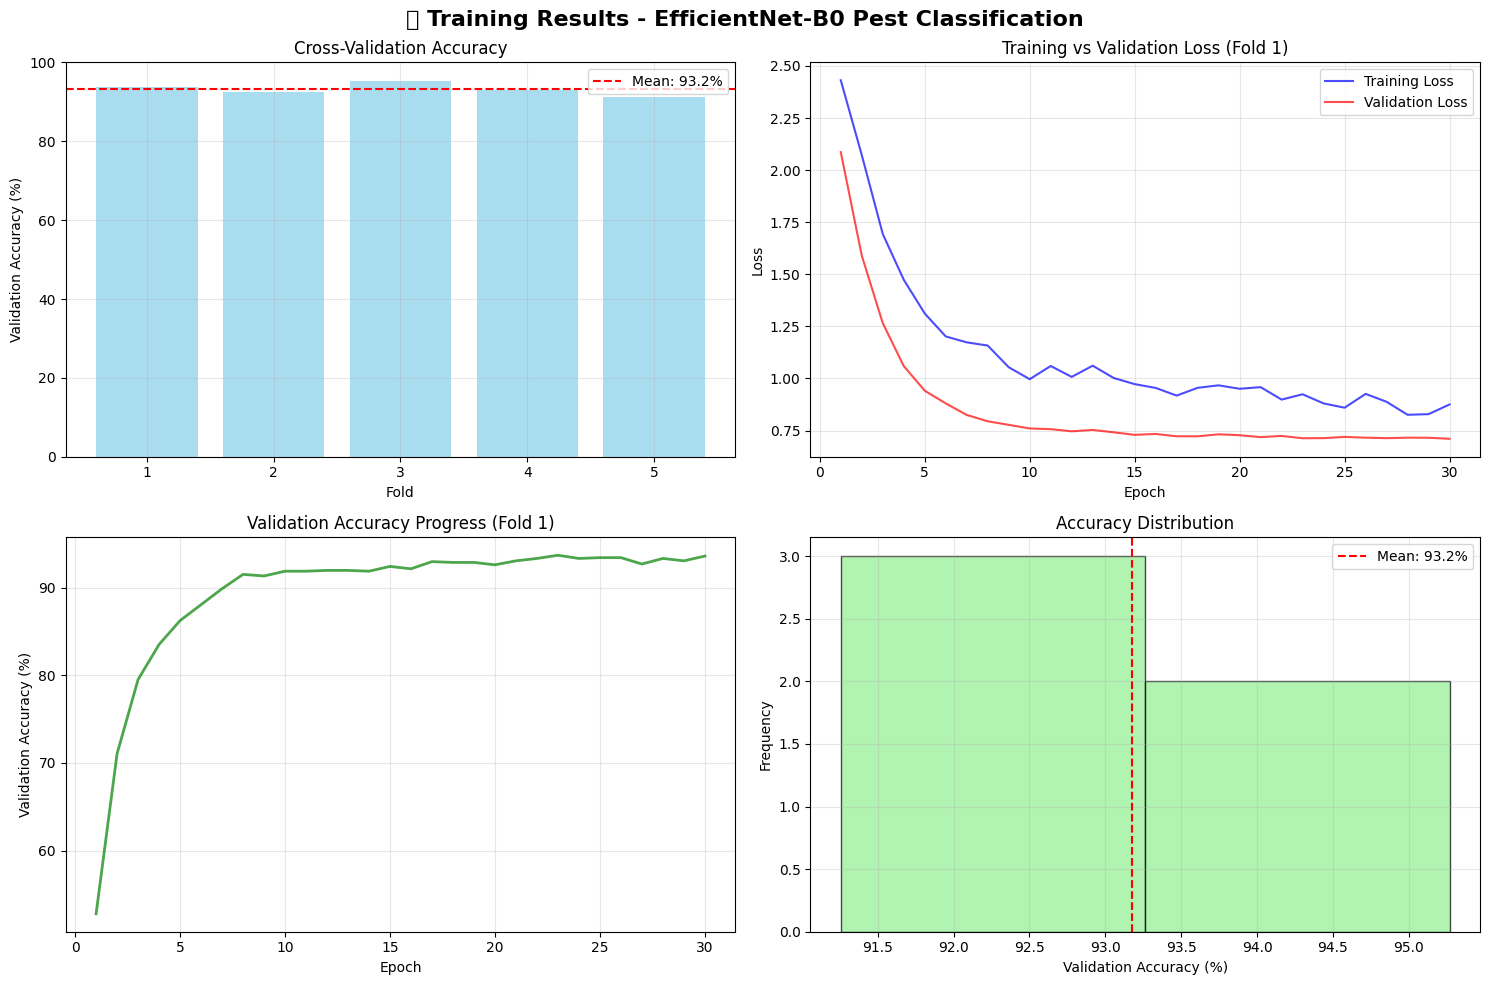

📊 Training visualization complete!


In [12]:
# Plot training results (if training was completed)
if 'fold_results' in locals():
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🌱 Training Results - EfficientNet-B0 Pest Classification', fontsize=16, fontweight='bold')
    
    # 1. Validation Accuracy across folds
    fold_accuracies = [result['best_val_acc'] for result in fold_results]
    axes[0, 0].bar(range(1, len(fold_accuracies) + 1), fold_accuracies, color='skyblue', alpha=0.7)
    axes[0, 0].axhline(y=np.mean(fold_accuracies), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(fold_accuracies):.1f}%')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Validation Accuracy (%)')
    axes[0, 0].set_title('Cross-Validation Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Training curves for first fold
    if len(fold_results) > 0:
        first_fold = fold_results[0]
        epochs = range(1, len(first_fold['train_losses']) + 1)
        
        axes[0, 1].plot(epochs, first_fold['train_losses'], 'b-', label='Training Loss', alpha=0.7)
        axes[0, 1].plot(epochs, first_fold['val_losses'], 'r-', label='Validation Loss', alpha=0.7)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Training vs Validation Loss (Fold 1)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Validation accuracy curve for first fold
    if len(fold_results) > 0:
        axes[1, 0].plot(epochs, first_fold['val_accuracies'], 'g-', linewidth=2, alpha=0.7)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Validation Accuracy (%)')
        axes[1, 0].set_title('Validation Accuracy Progress (Fold 1)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Accuracy distribution
    axes[1, 1].hist(fold_accuracies, bins=max(2, len(fold_accuracies)//2), 
                    color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=np.mean(fold_accuracies), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(fold_accuracies):.1f}%')
    axes[1, 1].set_xlabel('Validation Accuracy (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Accuracy Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Training visualization complete!")
    
else:
    print("⚠️ No training results to visualize - please run the training cell first")

## 🔍 Model Analysis

Analyze the trained models and their characteristics.

In [13]:
# Analyze training results
if 'cv_results' in locals():
    print("🔍 MODEL ANALYSIS")
    print("="*50)
    
    # Overall performance
    mean_acc = cv_results['mean_accuracy']
    std_acc = cv_results['std_accuracy']
    fold_accs = cv_results['fold_accuracies']
    
    print(f"📊 Cross-Validation Results:")
    print(f"   Mean Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"   Best Fold: {max(fold_accs):.1f}%")
    print(f"   Worst Fold: {min(fold_accs):.1f}%")
    print(f"   Range: {max(fold_accs) - min(fold_accs):.1f}%")
    
    # Model characteristics
    num_classes = cv_results['class_mapping']['num_classes']
    class_names = cv_results['class_mapping']['classes']
    
    print(f"\n🎯 Model Configuration:")
    print(f"   Architecture: EfficientNet-B0")
    print(f"   Number of Classes: {num_classes}")
    print(f"   Classes: {', '.join(class_names[:5])}{'...' if len(class_names) > 5 else ''}")
    print(f"   Input Size: {config['image_size']}x{config['image_size']}")
    print(f"   Training Device: {config['device'].upper()}")
    
    # Performance assessment for different use cases
    print(f"\n🎯 Use Case Assessment:")
    
    if mean_acc >= 90:
        print("   🏆 Research Grade: Excellent for academic publications")
    if mean_acc >= 85:
        print("   🚀 Production Ready: Suitable for commercial deployment")
    if mean_acc >= 75:
        print("   ✅ Farm Ready: Good for practical farm use with supervision")
    if mean_acc >= 65:
        print("   🧪 Development: Suitable for further development and testing")
    
    if std_acc <= 2:
        print("   🎯 Highly Consistent: Very stable across different data splits")
    elif std_acc <= 5:
        print("   ✅ Consistent: Acceptable stability for deployment")
    else:
        print("   ⚠️ Variable: Consider ensemble methods or more data")
    
    # Recommendations
    print(f"\n💡 Recommendations:")
    
    if mean_acc < 80:
        print("   📈 Collect more training data, especially for underperforming classes")
        print("   🔄 Try longer training or different augmentation strategies")
    
    if std_acc > 5:
        print("   🎯 Use ensemble of all folds for more stable predictions")
        print("   📊 Analyze class-wise performance for targeted improvements")
    
    if mean_acc >= 85 and std_acc <= 3:
        print("   🎉 Model is ready for production deployment!")
        print("   📱 Consider exporting to ONNX for mobile/edge deployment")
    
    print(f"\n📁 Next Steps:")
    print(f"   1. Test the models: python training/evaluate_model.py")
    print(f"   2. The improved detector will automatically load these models")
    print(f"   3. Models saved in: models/improved/")
    
else:
    print("⚠️ No results to analyze - please run training first")

🔍 MODEL ANALYSIS
📊 Cross-Validation Results:
   Mean Accuracy: 93.17% ± 1.32%
   Best Fold: 95.3%
   Worst Fold: 91.3%
   Range: 4.0%

🎯 Model Configuration:
   Architecture: EfficientNet-B0
   Number of Classes: 12
   Classes: ants, bees, beetle, catterpillar, earthworms...
   Input Size: 224x224
   Training Device: CUDA

🎯 Use Case Assessment:
   🏆 Research Grade: Excellent for academic publications
   🚀 Production Ready: Suitable for commercial deployment
   ✅ Farm Ready: Good for practical farm use with supervision
   🧪 Development: Suitable for further development and testing
   🎯 Highly Consistent: Very stable across different data splits

💡 Recommendations:
   🎉 Model is ready for production deployment!
   📱 Consider exporting to ONNX for mobile/edge deployment

📁 Next Steps:
   1. Test the models: python training/evaluate_model.py
   2. The improved detector will automatically load these models
   3. Models saved in: models/improved/


## 🧪 Quick Model Test

Test one of the trained models on a sample image.

In [14]:
# Test a trained model
if 'cv_results' in locals() and 'test_dataset' in locals():
    print("🧪 QUICK MODEL TEST")
    print("="*30)
    
    try:
        # Load the best model (first fold for simplicity)
        model_path = Path("models/improved/best_model_fold_0.pth")
        
        if model_path.exists():
            # Load model
            checkpoint = torch.load(model_path, map_location=config['device'])
            model = EfficientNetPestClassifier(num_classes=len(test_dataset.classes))
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            device = torch.device(config['device'])
            model = model.to(device)
            
            print(f"✅ Model loaded from {model_path}")
            
            # Get a random test image
            test_idx = random.randint(0, len(test_dataset) - 1)
            test_sample = test_dataset.samples[test_idx]
            test_path, true_class_idx = test_sample
            
            true_class_name = test_dataset.classes[true_class_idx]
            print(f"🖼️ Testing with: {Path(test_path).name}")
            print(f"🎯 True class: {true_class_name}")
            
            # Load and preprocess image
            augmentations = AgriculturalAugmentations()
            transform = augmentations.get_val_transforms()
            
            image = Image.open(test_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            # Run inference
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = F.softmax(outputs, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)
                
                predicted_class_name = test_dataset.classes[predicted_idx.item()]
                confidence_score = confidence.item()
            
            # Show results
            print(f"🔮 Predicted class: {predicted_class_name}")
            print(f"📊 Confidence: {confidence_score:.3f} ({confidence_score*100:.1f}%)")
            
            if predicted_class_name == true_class_name:
                print("✅ Prediction: CORRECT!")
            else:
                print("❌ Prediction: INCORRECT")
            
            # Show top 3 predictions
            top3_probs, top3_indices = torch.topk(probabilities, 3)
            print(f"\n📊 Top 3 Predictions:")
            for i in range(3):
                class_name = test_dataset.classes[top3_indices[0][i].item()]
                prob = top3_probs[0][i].item()
                print(f"   {i+1}. {class_name}: {prob:.3f} ({prob*100:.1f}%)")
        
        else:
            print(f"❌ Model file not found: {model_path}")
            print("   Please run the training cell first")
    
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        import traceback
        traceback.print_exc()

else:
    print("⚠️ Cannot test model - training results or dataset not available")

🧪 QUICK MODEL TEST
✅ Model loaded from models/improved/best_model_fold_0.pth
🖼️ Testing with: slug (372).jpg
🎯 True class: slug
🔮 Predicted class: slug
📊 Confidence: 0.954 (95.4%)
✅ Prediction: CORRECT!

📊 Top 3 Predictions:
   1. slug: 0.954 (95.4%)
   2. snail: 0.014 (1.4%)
   3. beetle: 0.008 (0.8%)
